In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pwd

/Users/julian/Documents/repos/pef/regresion_lineal


In [4]:
aord = pd.read_csv('data/ALLOrdinary.csv', index_col='Date')
nikkei = pd.read_csv('data/Nikkei225.csv', index_col='Date')
hsi = pd.read_csv('data/HSI.csv', index_col='Date')
daxi = pd.read_csv('data/DAXI.csv', index_col='Date')
cac40 = pd.read_csv('data/CAC40.csv', index_col='Date')
sp500 = pd.read_csv('data/SP500.csv', index_col='Date')
dji = pd.read_csv('data/DJI.csv', index_col='Date')
nasdaq = pd.read_csv('data/nasdaq_composite.csv', index_col='Date')
spy = pd.read_csv('data/SPY.csv', index_col='Date')

In [5]:
nasdaq.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,2653.909912,2661.500000,2597.810059,2609.629883,2609.629883,2076690000
2008-01-03,2611.959961,2624.270020,2592.179932,2602.679932,2602.679932,1970200000
2008-01-04,2571.080078,2571.080078,2502.679932,2504.649902,2504.649902,2516310000
2008-01-07,2514.149902,2521.620117,2471.229980,2499.459961,2499.459961,2600100000
2008-01-08,2506.969971,2527.419922,2440.510010,2440.510010,2440.510010,2566480000


# Paso 1: preprocesamiento de los datos

In [6]:
# Due to the timezone issues, we extract and calculate appropriate stock market data for analysis
# Indicepanel is the DataFrame of our trading model
indicepanel=pd.DataFrame(index=spy.index)

# Variable a predecir
indicepanel['spy']=spy['Open'].shift(-1)-spy['Open']

# Predictores
indicepanel['spy_lag1']=indicepanel['spy'].shift(1)
indicepanel['sp500']=sp500["Open"]-sp500['Open'].shift(1)
indicepanel['nasdaq']=nasdaq['Open']-nasdaq['Open'].shift(1)
indicepanel['dji']=dji['Open']-dji['Open'].shift(1)

indicepanel['cac40']=cac40['Open']-cac40['Open'].shift(1)
indicepanel['daxi']=daxi['Open']-daxi['Open'].shift(1)

indicepanel['aord']=aord['Close']-aord['Open']
indicepanel['hsi']=hsi['Close']-hsi['Open']
indicepanel['nikkei']=nikkei['Close']-nikkei['Open']
indicepanel['Price']=spy['Open']

In [7]:
indicepanel.head()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
Date,,,,,,,,,,,
2008-01-02,-1.619995,NaN,NaN,NaN,NaN,NaN,NaN,-50.100097,-71.679688,NaN,146.529999
2008-01-03,-1.570008,-1.619995,-20.419922,-41.949951,-217.70019,-71.779785,-104.450195,-2.300293,-162.750000,NaN,144.910004
2008-01-04,-1.529998,-1.570008,-3.540039,-40.879883,2.43945,5.489746,-27.990235,NaN,515.349609,-464.320313,143.339996
2008-01-07,0.270004,-1.529998,-29.940064,-56.930176,-245.40918,-111.689941,-102.709961,-27.500000,216.951171,-48.830078,141.809998
2008-01-08,-2.990006,0.270004,1.640015,-7.179931,19.75000,44.509766,33.680176,-33.899902,-354.060547,99.370117,142.080002


In [8]:
# Verificamos si tenemos NAN

In [9]:
# Lets check whether do we have NaN values in indicepanel
indicepanel.isnull().sum()

spy           1
spy_lag1      1
sp500         1
nasdaq        1
dji           1
cac40        30
daxi         53
aord        319
hsi         121
nikkei      145
Price         0
dtype: int64

In [10]:
# We can use method 'fillna()' from dataframe to forward filling the Nan values
# Then we can drop the reminding Nan values
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

In [11]:
# Lets check whether do we have Nan values in indicepanel now
indicepanel.isnull().sum()

spy         0
spy_lag1    0
sp500       0
nasdaq      0
dji         0
cac40       0
daxi        0
aord        0
hsi         0
nikkei      0
Price       0
dtype: int64

In [12]:
# save this indicepanel for part 4.5
path_save = 'data/indicepanel.csv'
indicepanel.to_csv(path_save)

In [13]:
print(indicepanel.shape)

(2677, 11)


# Split de los datos

In [14]:
#split the data into (1)train set and (2)test set

Train = indicepanel.iloc[-2000:-1000, :]
Test = indicepanel.iloc[-1000:, :]
print(Train.shape, Test.shape)

(1000, 11) (1000, 11)


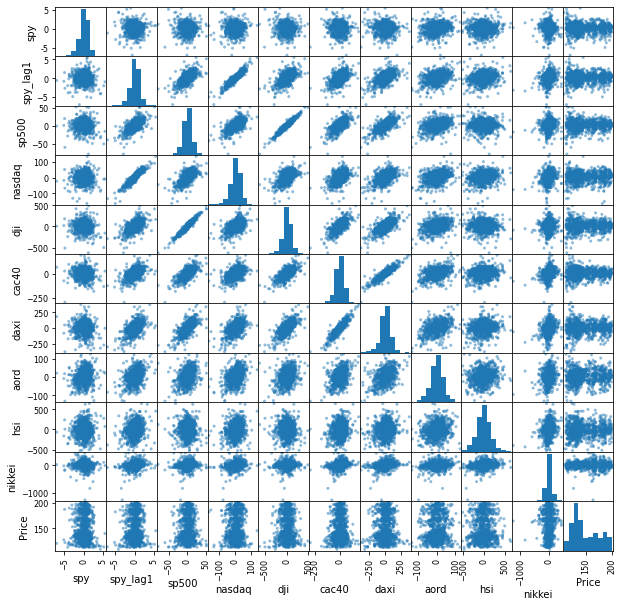

In [15]:
# Generate scatter matrix among all stock markets (and the price of SPY) to observe the association

from pandas.plotting import scatter_matrix
sm = scatter_matrix(Train, figsize=(10, 10))

In [16]:
# Find the indice with largest correlation
corr_array = Train.iloc[:, :-1].corr()['spy']
print(corr_array)

spy         1.000000
spy_lag1   -0.011623
sp500      -0.018632
nasdaq      0.012333
dji        -0.037097
cac40      -0.055304
daxi       -0.069735
aord        0.179638
hsi         0.031400
nikkei     -0.035048
Name: spy, dtype: float64


In [17]:
formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.962
Date:                Wed, 09 Sep 2020   Prob (F-statistic):           1.97e-11
Time:                        17:03:12   Log-Likelihood:                -1617.7
No. Observations:                1000   AIC:                             3255.
Df Residuals:                     990   BIC:                             3305.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0836      0.039      2.138      0.033       0.007       0.160
spy_lag1      -0.1567      0.091     -1.730      0.084      -0.335       0.021
sp500          0.0221      0.014      1.621      0.105      -0.005       0.049
nasdaq         0.0040      0.004      1.066      0.287      -0.003       0.011
dji           -0.0018      0.001     -1.248      0.212      -0.005       0.001
cac40         -0.0003      0.002     -0.153      0.879      -0.004       0.004
aord           0.0093      0.001      7.492      0.000       0.007       0.012
daxi          -0.0025      0.001     -2.387      0.017      -0.005      -0.000
nikkei        -0.0004      0.000     -1.264      0.207      -0.001       0.000
hsi            0.0003      0.000      1.222      0.222      -0.000       0.001
==============================================================================
Omnibus:                       91.018   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.687
Skew:                          -0.450   Prob(JB):                     7.45e-59
Kurtosis:                       5.369   Cond. No.                         405.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""